# Exercise 2: Neural Networks

In the previous exercise you implemented a binary classifier with one linear layer on a small portion of CIFAR-10. In this exercise, you will first implement a multi-class logistic regression model followed by a three layer neural network.

## Submission guidelines:

**Zip** all the files in the exercise directory excluding the data. Name the file `ex2_ID.zip`.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. 
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Do not change the functions we provided you. 
4. Write your functions in the instructed python modules only. All the logic you write is imported and used using this jupyter notebook. You are allowed to add functions as long as they are located in the python modules and are imported properly.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden.
6. Your code must run without errors. Use `python 3` and `numpy 1.15.4`.
7. **Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works. Code that cannot run will not be tested.**
8. Write your own code. Cheating will not be tolerated. 
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support).

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)

Python version:  3.7.1
Numpy version:  1.15.4


# Logistic Regression

During this exercise, you are allowed (and encouraged) to use your code from HW1.

## Load Data - CIFAR-10

The next few cells will download and extract CIFAR-10 into `datasets/cifar10/` - notice you can copy and paste this dataset from the previous exercise or just download it again. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class.


In [3]:
from datasets import load_cifar10
URL = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/' # the script will create required directories
load_cifar10.maybe_download_and_extract(URL, PATH) 

Data has apparently already been downloaded and unpacked.


In [4]:
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load_cifar10.load(CIFAR10_PATH) # load the entire data

# define a splitting for the data
num_training = 49000
num_validation = 1000
num_testing = 1000

# add a validation dataset for hyperparameter optimization
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]
mask = range(num_validation, num_validation+num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# float64
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
X_test = X_test.astype(np.float64)

# subtract the mean from all the images in the batch
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# flatten all the images in the batch (make sure you understand why this is needed)
X_train = np.reshape(X_train, newshape=(X_train.shape[0], -1))
X_val = np.reshape(X_val, newshape=(X_val.shape[0], -1)) 
X_test = np.reshape(X_test, newshape=(X_test.shape[0], -1)) 

# add a bias term to all images in the batch
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]) 
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]) 
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]) 

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(49000, 3073)
(1000, 3073)
(1000, 3073)


         bird           car         plane          ship


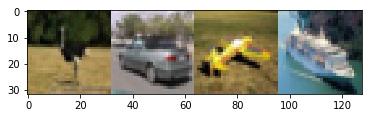

In [5]:
def get_batch(X, y, n):
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return X, y

def make_random_grid(x, y, n=4):
    rand_items = np.random.randint(0, x.shape[0], size=n)
    images = x[rand_items]
    labels = y[rand_items]
    grid = np.hstack((np.asarray((vec_2_img(i) + mean_image), dtype=np.int) for i in images))
    print(' '.join('%13s' % classes[labels[j]] for j in range(4)))
    return grid

def vec_2_img(x):
    x = np.reshape(x[:-1], (32, 32, 3))
    return x

X_batch, y_batch = get_batch(X_test, y_test, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

Open the file `functions/classifier.py`. The constructor of the `LogisticRegression` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LogisticRegression` class. **5 points**

You can use your code from HW1. If you used vectorized code well, you should make very little changes.

        horse         plane          ship         truck


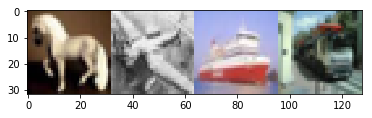

In [6]:
from functions.classifier import LogisticRegression

classifier = LogisticRegression(X_train, y_train)
y_pred = classifier.predict(X_test)
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

In [7]:
print(' '.join('%13s' % classes[y_pred[j]] for j in range(4)))

          dog          deer          frog          frog


In [8]:
print("model accuracy: ", classifier.calc_accuracy(X_train, y_train))

model accuracy:  10.118367346938776


## Cross-entropy

Open the file `functions/losses.py`. Complete the function `softmax_loss_vectorized` using vectorized code. This function takes as input the weights `W`, data `X`, labels `y` and a regularization term `reg` and outputs the calculated loss as a single number and the gradients with respect to W. Don't forget the regularization. **5 points**

In [9]:
from functions.losses import softmax_loss_vectorized
W = np.random.randn(3073, 10) * 0.0001
loss_naive, grad_naive = softmax_loss_vectorized(W, X_val, y_val, 0.00000)
print ('loss: %f' % (loss_naive, ))
print ('sanity check: %f' % (-np.log(0.1))) # should be close but not the same

loss: 2.330776
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? **Explain briefly.**

**Your answer:** As HW1, W is set to random number so the probability is 1 to number of classes (10).

Use the following cell to test your implementation of the gradients.

In [10]:
from functions.losses import grad_check

loss, grad = softmax_loss_vectorized(W, X_val, y_val, 1)
f = lambda w: softmax_loss_vectorized(W, X_val, y_val, 1)[0]
grad_numerical = grad_check(f, W, grad, num_checks=10)

numerical: 5.910014 analytic: 5.910014, relative error: 1.538303e-08
numerical: 1.321569 analytic: 1.321569, relative error: 4.748758e-09
numerical: -1.767665 analytic: -1.767665, relative error: 6.676704e-09
numerical: -0.417281 analytic: -0.417281, relative error: 1.306207e-08
numerical: 1.191300 analytic: 1.191300, relative error: 5.517276e-09
numerical: 2.292188 analytic: 2.292188, relative error: 1.766513e-08
numerical: 0.865887 analytic: 0.865887, relative error: 2.649307e-08
numerical: -0.322733 analytic: -0.322733, relative error: 1.536894e-07
numerical: 1.446202 analytic: 1.446202, relative error: 1.151324e-08
numerical: -0.369147 analytic: -0.369147, relative error: 7.523488e-08


In [11]:
from functions.classifier import LogisticRegression

logistic = LogisticRegression(X_train, y_train)
loss_history = logistic.train(X_train, y_train, 
                         learning_rate=1e-7,
                         reg=5e4, 
                         num_iters=1500,
                         verbose=True)

iteration 0 / 1500: loss 17.750580
iteration 100 / 1500: loss 17.506427
iteration 200 / 1500: loss 17.444309
iteration 300 / 1500: loss 17.673264
iteration 400 / 1500: loss 17.720565
iteration 500 / 1500: loss 17.723606
iteration 600 / 1500: loss 17.914191
iteration 700 / 1500: loss 17.954574
iteration 800 / 1500: loss 18.080064
iteration 900 / 1500: loss 18.144980
iteration 1000 / 1500: loss 18.172421
iteration 1100 / 1500: loss 18.283781
iteration 1200 / 1500: loss 18.362571
iteration 1300 / 1500: loss 18.466156
iteration 1400 / 1500: loss 18.508409


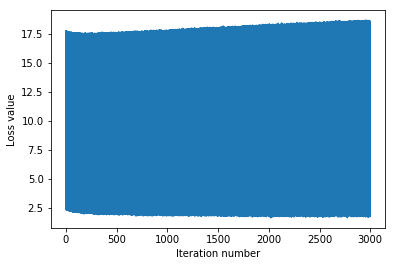

In [12]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [13]:
print("Training accuracy: ", logistic.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", logistic.calc_accuracy(X_test, y_test))

Training accuracy:  37.9
Testing accuracy:  38.7


Use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset.

In [14]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
regularization_strengths = [5e4, 1e5, 5e3, 1e2]
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_logistic = None # The LogisticRegression object that achieved the highest validation score.
################################################################################
#                            START OF YOUR CODE                                #
################################################################################
iters = 2000

for learning_rate in learning_rates:
    for reg_strength in regularization_strengths:
        log_reg = LogisticRegression(X_train, y_train)
        log_reg.train(X_train, y_train, learning_rate=learning_rate, reg=reg_strength, num_iters=iters)
        
        y_train_pred = log_reg.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        y_val_pred = log_reg.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(learning_rate, reg_strength)] = (acc_train, acc_val)
        
        if best_val < acc_val:
            best_val = acc_val
            best_logistic = log_reg
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = logistic.calc_accuracy(X_test, y_test)
print ('Binary logistic regression on raw pixels final test set accuracy: %f' % test_accuracy)

lr 1.000000e-07 reg 1.000000e+02 train accuracy: 0.386143 val accuracy: 0.371000
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.389265 val accuracy: 0.384000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.389020 val accuracy: 0.382000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.388490 val accuracy: 0.390000
lr 5.000000e-06 reg 1.000000e+02 train accuracy: 0.414122 val accuracy: 0.355000
lr 5.000000e-06 reg 5.000000e+03 train accuracy: 0.411224 val accuracy: 0.366000
lr 5.000000e-06 reg 5.000000e+04 train accuracy: 0.406327 val accuracy: 0.369000
lr 5.000000e-06 reg 1.000000e+05 train accuracy: 0.421082 val accuracy: 0.373000
best validation accuracy achieved during cross-validation: 0.390000
Binary logistic regression on raw pixels final test set accuracy: 38.700000


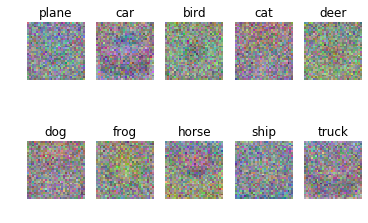

In [15]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
w = best_logistic.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

## Neural Network

The implementation of linear regression was (hopefully) simple yet not very modular since the layer, loss and gradient were calculated as a single monolithic function. This would become impractical as we move towards bigger models. As a warmup towards `PyTorch`, we want to build networks using a more modular design so that we can implement different layer types in isolation and easily integrate them together into models with different architectures.

This logic of isolation & integration is at the heart of all popular deep learning frameworks, and is based on two methods each layer holds - a forward and backward pass. The forward function will receive inputs, weights and other parameters and will return both an output and a cache object storing data needed for the backward pass. The backward pass will receive upstream derivatives and the cache, and will return gradients with respect to the inputs and weights. By implementing several types of layers this way, we will be able to easily combine them to build classifiers with different architectures with relative ease.

We will implement a neural network to obtain better results on CIFAR-10. If you were careful, you should have got a classification accuracy of over 38% on the test set using a simple single layer network. However, using multiple layers we could reach around 50% accuracy. Our neural network will be implemented in the file `functions/neural_net.py`. We will train this network using softmax loss and L2 regularization and a ReLU non-linearity after the first two fully connected layers.

### Fully Connected Layer: Forward Pass.

Open the file `functions/layers.py` and implement the function `fc_forward` **7.5 points**.

In [16]:
np.random.seed(42)
from functions.layers import * 

num_instances = 5
input_shape = (11, 7, 3)
output_shape = 4

X = np.random.randn(num_instances * np.prod(input_shape)).reshape(num_instances, *input_shape)
W = np.random.randn(np.prod(input_shape) * output_shape).reshape(np.prod(input_shape), output_shape)
b = np.random.randn(output_shape)

out, _ = fc_forward(X, W, b)

correct_out = np.array([[16.77132953,  1.43667172, -15.60205534,   7.15789287],
                        [ -8.5994206,  7.59104298,  10.92160126,  17.19394331],
                        [ 4.77874003,  2.25606192,  -6.10944859,  14.76954561],
                        [21.21222953, 17.82329258,   4.53431782,  -9.88327913],
                        [18.83041801, -2.55273817,  14.08484003,  -3.99196171]])

print(np.isclose(out, correct_out, rtol=1e-8).all()) # simple test

True


## Fully Connected Layer: Backward Pass

Open the file `functions/layers.py` and implement the function `fc_backward` **7.5 points**.

In [17]:
np.random.seed(42)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: fc_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: fc_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: fc_forward(x, w, b)[0], b, dout)

out, cache = fc_forward(x,w,b)
dx, dw, db = fc_backward(dout, cache)

np.isclose(dw, dw_num, rtol=1e-8).all() # simple test
np.isclose(dx, dx_num, rtol=1e-8).all() # simple test
np.isclose(db, db_num, rtol=1e-8).all() # simple test

True

## ReLU: Forward Pass

Open the file `functions/layers.py` and implement the function `relu_forward` **7.5 points**.

In [18]:
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)
out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

print(np.isclose(out, correct_out, rtol=1e-8).all()) # simple test

True


## ReLU: Backward Pass

Open the file `functions/layers.py` and implement the function `relu_backward` **7.5 points**.

In [19]:
np.random.seed(42)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)
dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)
xx, cache = relu_forward(x)
dx = relu_backward(dout, cache)

np.isclose(dx, dx_num, rtol=1e-8).all()  # simple test

True

**Optional**: you are given two helper functions in `functions/layers.py` - `fc_relu_forward` and `fc_relu_backward`. You might find it beneficial to use dedicated functions to calculate the forward and backward outputs of a fully connected layer immediately followed by a ReLU.

# Building the Network

First, notice that we are leaving behind the bias trick and removing the bias from each image. 

In [20]:
X_train = np.array([x[:-1] for x in X_train])
X_val = np.array([x[:-1] for x in X_val])
X_test = np.array([x[:-1] for x in X_test])
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(49000, 3072)
(1000, 3072)
(1000, 3072)


Open the file `functions/neural_net.py` and complete the class `ThreeLayerNet`. All the implementation details are available in the file itself. Read the documentation carefully since the class of this network is slightly different from the network in the previous section of this exercise. **50 points**

In [88]:
from functions.neural_net import ThreeLayerNet
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = ThreeLayerNet(input_size, hidden_size, num_classes)

input_size = 3072
hidden_size = 50
output_size = 10


In [89]:
stats = model.train(X_train, y_train, X_val, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=1e-3, reg=0, verbose=True)

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
iteration 0 / 1500: loss 2.308754
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
###

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
iteration 100 / 1500: loss 2.231932
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (

dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shap

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shap

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shap

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (

out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.

dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shap

out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shap

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
iteration 700 / 1500: loss 1.764195
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shap

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shap

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shap

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shap

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shap

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
iteration 900 / 1500: loss 1.815505
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = 

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shap

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shap

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (

out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (

dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shap

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50

out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shap

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shap

W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (

db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
###################

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shap

dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shape = (3072, 50)
b1.shape = (50,)
W2.shape = (50, 50)
b2.shape = (50,)
W3.shape = (50, 10)
b3.shape = (10,)
x.shape = (200, 3072)
#####################
out_1.shape = (200, 50)
out_2.shape = (200, 50)
dx3.shape = (200, 50)
dx2.shape = (200, 50)
dx1.shape = (200, 3072)
#####################
dW3.shape = (50, 10)
db3.shape = (10,)
dW2.shape = (50, 50)
db2.shape = (50,)
dW1.shape = (3072, 50)
db1.shape = (50,)
W1.shap

In [90]:
val_acc = (model.predict(X_val) == y_val).mean()
print ('Validation accuracy: ', val_acc)

Validation accuracy:  0.406


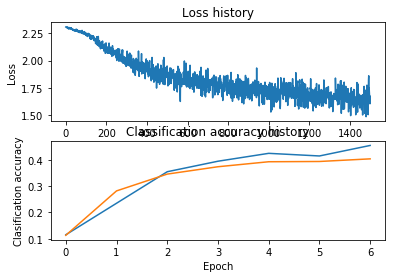

In [91]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

Use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, hidden_size, regularization)` to tuples of the form `(training_accuracy, validation_accuracy)`. You should evaluate the best model on the testing dataset and print out the training, validation and testing accuracies for each of the models and provide a clear visualization. Highlight the best model w.r.t the testing accuracy. **10 points**

In [ ]:
# You are encouraged to experiment with additional values
learning_rates = [1e-3, 1e-7, 5e-6, 1e-7, 5e-8, 1e-7, 1e-5] # this time its up to you
hidden_sizes = [10, 20 ,30 ,40, 50, 60 ,70, 100, 200, 300, 1000] # this time its up to you
regularizations = [0,1, 5e-6, 5e-7, 5e-8, 1e-6, 1e-5, 1e-4, 1e-7,] # this time its up to you

results = {}
best_values = None
best_val = -1   
best_net = None 
################################################################################
#                            START OF YOUR CODE                                #
################################################################################
batch_size = 200
num_of_samples = X_train.shape[0]
print(num_of_samples)
epochs = 200*600/num_of_samples

for lr in learning_rates:
    for hs in hidden_sizes:
        for r in regularizations:
            num_iters = int(epochs*num_of_samples/batch_size)
            model = ThreeLayerNet(input_size, hs, num_classes)
            stats = model.train(X_train, y_train, X_val, y_val,
                                num_iters=num_iters, batch_size=200,
                                learning_rate=lr, reg=r, verbose=True)
            val_accuracy = stats['val_acc_history']
            train_accuracy = stats['train_acc_history']
            print('(learning_rate, hidden_size, regularization) = {}'.format((lr, hs, r)))
            print('(train_accuracy,val_accuracy) = {}'.format((train_accuracy,val_accuracy)))
            results[(lr, hs, r)] = (train_accuracy,val_accuracy)
            if val_accuracy[-1] > best_val:
                best_val = val_accuracy[-1]
                best_values = (lr, hs, r)
                best_net = model
            

print('best value = {}'.format(best_values))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

49000
iteration 0 / 600: loss 2.304608
iteration 100 / 600: loss 2.299699
iteration 200 / 600: loss 2.296006
iteration 300 / 600: loss 2.269787
iteration 400 / 600: loss 2.187682
iteration 500 / 600: loss 2.111569
(learning_rate, hidden_size, regularization) = (0.001, 10, 0)
(train_accuracy,val_accuracy) = ([0.065, 0.1, 0.18], [0.089, 0.152, 0.167])
iteration 0 / 600: loss 2.301936
iteration 100 / 600: loss 2.300196
iteration 200 / 600: loss 2.300095
iteration 300 / 600: loss 2.301098
iteration 400 / 600: loss 2.300433
iteration 500 / 600: loss 2.298947
(learning_rate, hidden_size, regularization) = (0.001, 10, 1)
(train_accuracy,val_accuracy) = ([0.135, 0.18, 0.15], [0.118, 0.128, 0.136])
iteration 0 / 600: loss 2.303015
iteration 100 / 600: loss 2.297826
iteration 200 / 600: loss 2.285715
iteration 300 / 600: loss 2.223644
iteration 400 / 600: loss 2.220416
iteration 500 / 600: loss 2.181709
(learning_rate, hidden_size, regularization) = (0.001, 10, 5e-06)
(train_accuracy,val_accurac

iteration 400 / 600: loss 2.081051
iteration 500 / 600: loss 2.005051
(learning_rate, hidden_size, regularization) = (0.001, 30, 1e-06)
(train_accuracy,val_accuracy) = ([0.11, 0.195, 0.31], [0.093, 0.224, 0.267])
iteration 0 / 600: loss 2.300567
iteration 100 / 600: loss 2.257676
iteration 200 / 600: loss 2.152570
iteration 300 / 600: loss 2.061190
iteration 400 / 600: loss 2.039190
iteration 500 / 600: loss 1.971822
(learning_rate, hidden_size, regularization) = (0.001, 30, 1e-05)
(train_accuracy,val_accuracy) = ([0.085, 0.205, 0.26], [0.092, 0.231, 0.285])
iteration 0 / 600: loss 2.302745
iteration 100 / 600: loss 2.257326
iteration 200 / 600: loss 2.155674
iteration 300 / 600: loss 2.069029
iteration 400 / 600: loss 2.077872
iteration 500 / 600: loss 1.990775
(learning_rate, hidden_size, regularization) = (0.001, 30, 0.0001)
(train_accuracy,val_accuracy) = ([0.105, 0.22, 0.29], [0.086, 0.257, 0.303])
iteration 0 / 600: loss 2.305766
iteration 100 / 600: loss 2.266535
iteration 200 /

iteration 100 / 600: loss 2.177894
iteration 200 / 600: loss 2.053107
iteration 300 / 600: loss 1.913138
iteration 400 / 600: loss 1.885740
iteration 500 / 600: loss 1.840470
(learning_rate, hidden_size, regularization) = (0.001, 60, 5e-06)
(train_accuracy,val_accuracy) = ([0.085, 0.29, 0.36], [0.117, 0.287, 0.34])
iteration 0 / 600: loss 2.311196
iteration 100 / 600: loss 2.220958
iteration 200 / 600: loss 2.079225
iteration 300 / 600: loss 1.979690
iteration 400 / 600: loss 1.767762
iteration 500 / 600: loss 1.849123
(learning_rate, hidden_size, regularization) = (0.001, 60, 5e-07)
(train_accuracy,val_accuracy) = ([0.105, 0.28, 0.315], [0.088, 0.286, 0.339])
iteration 0 / 600: loss 2.308526
iteration 100 / 600: loss 2.215973
iteration 200 / 600: loss 2.081395
iteration 300 / 600: loss 2.016117
iteration 400 / 600: loss 1.886003
iteration 500 / 600: loss 1.932919
(learning_rate, hidden_size, regularization) = (0.001, 60, 5e-08)
(train_accuracy,val_accuracy) = ([0.07, 0.27, 0.305], [0.

iteration 500 / 600: loss 1.675841
(learning_rate, hidden_size, regularization) = (0.001, 100, 0.0001)
(train_accuracy,val_accuracy) = ([0.1, 0.315, 0.4], [0.097, 0.323, 0.384])
iteration 0 / 600: loss 2.313781
iteration 100 / 600: loss 2.074563
iteration 200 / 600: loss 1.938775
iteration 300 / 600: loss 1.842339
iteration 400 / 600: loss 1.793601
iteration 500 / 600: loss 1.844204
(learning_rate, hidden_size, regularization) = (0.001, 100, 1e-07)
(train_accuracy,val_accuracy) = ([0.095, 0.345, 0.355], [0.092, 0.329, 0.365])
iteration 0 / 600: loss 2.306021
iteration 100 / 600: loss 1.942766
iteration 200 / 600: loss 1.739168
iteration 300 / 600: loss 1.725235
iteration 400 / 600: loss 1.679800
iteration 500 / 600: loss 1.704364
(learning_rate, hidden_size, regularization) = (0.001, 200, 0)
(train_accuracy,val_accuracy) = ([0.135, 0.425, 0.37], [0.097, 0.353, 0.386])
iteration 0 / 600: loss 2.352915
iteration 100 / 600: loss 1.962274
iteration 200 / 600: loss 1.982274
iteration 300 / 

iteration 0 / 600: loss 3.421769
iteration 100 / 600: loss 1.777427
iteration 200 / 600: loss 1.662052
iteration 300 / 600: loss 1.656646
iteration 400 / 600: loss 1.568500
iteration 500 / 600: loss 1.458717
(learning_rate, hidden_size, regularization) = (0.001, 1000, 5e-08)
(train_accuracy,val_accuracy) = ([0.17, 0.53, 0.6], [0.124, 0.417, 0.452])
iteration 0 / 600: loss 3.403082
iteration 100 / 600: loss 1.830106
iteration 200 / 600: loss 1.589515
iteration 300 / 600: loss 1.480041
iteration 400 / 600: loss 1.565935
iteration 500 / 600: loss 1.574757
(learning_rate, hidden_size, regularization) = (0.001, 1000, 1e-06)
(train_accuracy,val_accuracy) = ([0.175, 0.485, 0.61], [0.146, 0.38, 0.444])
iteration 0 / 600: loss 5.531093
iteration 100 / 600: loss 1.888495
iteration 200 / 600: loss 1.520520
iteration 300 / 600: loss 1.573977
iteration 400 / 600: loss 1.392697
iteration 500 / 600: loss 1.381809
(learning_rate, hidden_size, regularization) = (0.001, 1000, 1e-05)
(train_accuracy,val_

iteration 400 / 600: loss 2.300189
iteration 500 / 600: loss 2.295723
(learning_rate, hidden_size, regularization) = (1e-07, 30, 0)
(train_accuracy,val_accuracy) = ([0.14, 0.12, 0.115], [0.089, 0.089, 0.089])
iteration 0 / 600: loss 2.299577
iteration 100 / 600: loss 2.297538
iteration 200 / 600: loss 2.291199
iteration 300 / 600: loss 2.299927
iteration 400 / 600: loss 2.293045
iteration 500 / 600: loss 2.299459
(learning_rate, hidden_size, regularization) = (1e-07, 30, 1)
(train_accuracy,val_accuracy) = ([0.14, 0.155, 0.155], [0.151, 0.151, 0.151])
iteration 0 / 600: loss 2.311705
iteration 100 / 600: loss 2.302160
iteration 200 / 600: loss 2.312515
iteration 300 / 600: loss 2.307362
iteration 400 / 600: loss 2.311108
iteration 500 / 600: loss 2.304003
(learning_rate, hidden_size, regularization) = (1e-07, 30, 5e-06)
(train_accuracy,val_accuracy) = ([0.07, 0.075, 0.1], [0.096, 0.096, 0.096])
iteration 0 / 600: loss 2.305789
iteration 100 / 600: loss 2.303947
iteration 200 / 600: loss

iteration 100 / 600: loss 2.301913
iteration 200 / 600: loss 2.311456
iteration 300 / 600: loss 2.312374
iteration 400 / 600: loss 2.306408
iteration 500 / 600: loss 2.316234
(learning_rate, hidden_size, regularization) = (1e-07, 50, 1e-05)
(train_accuracy,val_accuracy) = ([0.085, 0.075, 0.075], [0.077, 0.077, 0.077])
iteration 0 / 600: loss 2.309375
iteration 100 / 600: loss 2.298853
iteration 200 / 600: loss 2.305154
iteration 300 / 600: loss 2.310787
iteration 400 / 600: loss 2.306384
iteration 500 / 600: loss 2.305351
(learning_rate, hidden_size, regularization) = (1e-07, 50, 0.0001)
(train_accuracy,val_accuracy) = ([0.085, 0.095, 0.09], [0.085, 0.085, 0.085])
iteration 0 / 600: loss 2.312044
iteration 100 / 600: loss 2.309469
iteration 200 / 600: loss 2.307823
iteration 300 / 600: loss 2.301427
iteration 400 / 600: loss 2.303464
iteration 500 / 600: loss 2.305785
(learning_rate, hidden_size, regularization) = (1e-07, 50, 1e-07)
(train_accuracy,val_accuracy) = ([0.105, 0.105, 0.07]

(learning_rate, hidden_size, regularization) = (1e-07, 100, 5e-06)
(train_accuracy,val_accuracy) = ([0.1, 0.11, 0.075], [0.093, 0.093, 0.093])
iteration 0 / 600: loss 2.288885
iteration 100 / 600: loss 2.288366
iteration 200 / 600: loss 2.296466
iteration 300 / 600: loss 2.298847
iteration 400 / 600: loss 2.293996
iteration 500 / 600: loss 2.272943
(learning_rate, hidden_size, regularization) = (1e-07, 100, 5e-07)
(train_accuracy,val_accuracy) = ([0.15, 0.095, 0.15], [0.118, 0.118, 0.118])
iteration 0 / 600: loss 2.313772
iteration 100 / 600: loss 2.324639
iteration 200 / 600: loss 2.297101
iteration 300 / 600: loss 2.310627
iteration 400 / 600: loss 2.318200
iteration 500 / 600: loss 2.324977
(learning_rate, hidden_size, regularization) = (1e-07, 100, 5e-08)
(train_accuracy,val_accuracy) = ([0.1, 0.13, 0.105], [0.121, 0.121, 0.121])
iteration 0 / 600: loss 2.331421
iteration 100 / 600: loss 2.329812
iteration 200 / 600: loss 2.323673
iteration 300 / 600: loss 2.336531
iteration 400 / 

iteration 100 / 600: loss 2.410053
iteration 200 / 600: loss 2.353925
iteration 300 / 600: loss 2.445381
iteration 400 / 600: loss 2.352654
iteration 500 / 600: loss 2.362111
(learning_rate, hidden_size, regularization) = (1e-07, 300, 1e-07)
(train_accuracy,val_accuracy) = ([0.125, 0.095, 0.115], [0.11, 0.111, 0.112])
iteration 0 / 600: loss 3.526685
iteration 100 / 600: loss 3.743083
iteration 200 / 600: loss 3.402642
iteration 300 / 600: loss 3.513470
iteration 400 / 600: loss 3.571785
iteration 500 / 600: loss 3.486897
(learning_rate, hidden_size, regularization) = (1e-07, 1000, 0)
(train_accuracy,val_accuracy) = ([0.105, 0.1, 0.115], [0.091, 0.088, 0.084])
iteration 0 / 600: loss 3.154729
iteration 100 / 600: loss 3.040539
iteration 200 / 600: loss 3.188814
iteration 300 / 600: loss 3.190486
iteration 400 / 600: loss 3.130688
iteration 500 / 600: loss 3.271141
(learning_rate, hidden_size, regularization) = (1e-07, 1000, 1)
(train_accuracy,val_accuracy) = ([0.09, 0.09, 0.1], [0.109,

## Inline Question 2:
What can you say about the training? Why does it take much longer to train? How could you speed up computation? What would happen to the network accuracy and training time when adding additional layer? What about additional hidden neurons?

**Your answer:** 
*THe  training process takes much longer, We think that it takes much longer to run because we added more layers and the forward and backwards passes takes high computaional effort.
we could speed up the computation by using GPU, stronger CPU and writing a better efficeint code, maybe using C++ could improve python overhead.
If we would add more layer the training time will increase, while the accuuracy might improve and might not.
We are not sure about hidden neurons*

## Bonus 
Train a 5 hidden layer network with varying hidden layer size and plot the loss function and train / validation accuracies. **5 points**

In [ ]:
## Your code here ##